**<h1><center>Machine Learning For Signal Processing (ENGR-E 511) 
<br>Homework 6 , Spring 2022</h1>**

**Name: Anitha Ganapathy** <br>
**Email: aganapa@iu.edu** <br>


___

Organizing the imports

In [1]:
# !pip install ipympl

In [2]:
# Import the necessary libraries

from mpl_toolkits.mplot3d import Axes3D
from google.colab import output
output.enable_custom_widget_manager()

from PIL import Image
# from scipy.misc import imread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
import librosa
import soundfile as sf
from IPython.display import Audio
import cmath, math
import scipy.io  # to read .mat files
import seaborn as sns
from numpy.core.fromnumeric import size
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from numpy.linalg import eigh

%matplotlib inline
from google.colab import drive

drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dirpath = '/content/drive/MyDrive/MLSP_data/'
!ls $dirpath

'HW_1 data'  'HW_3 data'   im0.ppm   tes.wav   trn.wav	 twitter.mat
'HW_2 data'   HW4	   im8.ppm   tex.wav   trs.wav


## **P1: Stereo Matching (revisited)**

Left Image shape : (381, 430, 3), Right Image shape : (381, 430, 3)


Text(0.5, 1.0, 'Right')

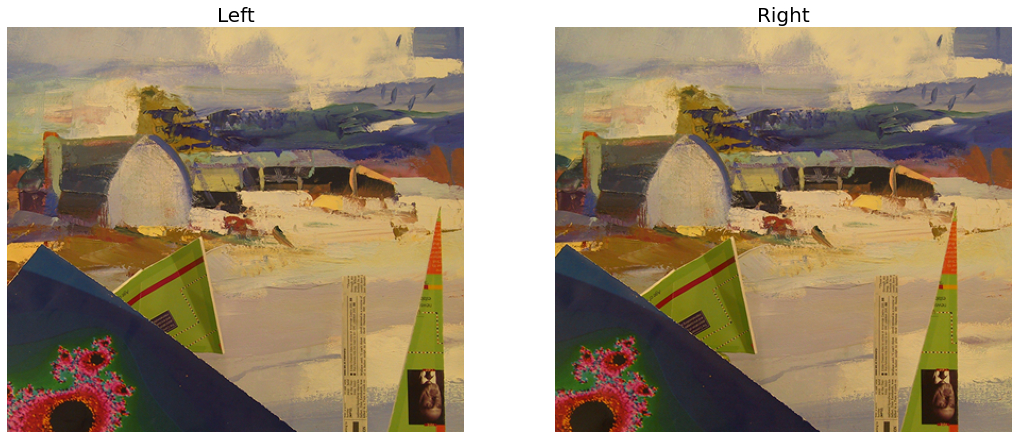

In [4]:
X_L = plt.imread(dirpath + "im0.ppm")
X_R = plt.imread(dirpath + "im8.ppm")
print(f"Left Image shape : {X_L.shape}, Right Image shape : {X_R.shape}")


fig = plt.figure(figsize=(18, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(X_L)
plt.axis('off')
plt.title("Left", fontsize = 20)

fig.add_subplot(1, 2, 2)
plt.imshow(X_R)
plt.axis('off')
plt.title("Right", fontsize = 20)

In [5]:
print(f"Left Image shape : {X_L.shape}, Right Image shape : {X_R.shape}")

def similar_of_40_pixels(i, j):
  similar_idx = 0
  similarity_threshold = np.inf
  for k in range(40):
    distance = np.sqrt(np.sum(np.abs(X_R[i,j, :] - X_L[i,j + k, :])))
    if distance < similarity_threshold:
      similarity_threshold =distance
      similar_idx = k
  return similar_idx

Left Image shape : (381, 430, 3), Right Image shape : (381, 430, 3)


### **Calculating the Disparity Matrix**

In [6]:
D = np.zeros((X_L.shape[0], X_L.shape[1] - 40), dtype=int)
print(D.shape)

# Calculating the Disparity Matrix
for i in range(D.shape[0]):
  for j in range(D.shape[1]):
    D[i, j ] = similar_of_40_pixels(i, j)

print(D)

(381, 390)
[[ 5 13 11 ... 20 25  7]
 [ 0  4  3 ... 17 17  4]
 [ 5  5  7 ... 18 12 11]
 ...
 [16 26 37 ... 26 35 26]
 [32 34 21 ... 32 31  4]
 [22 34 24 ... 28 32 33]]


In [7]:
print(D.shape)
D[:,:]

(381, 390)


array([[ 5, 13, 11, ..., 20, 25,  7],
       [ 0,  4,  3, ..., 17, 17,  4],
       [ 5,  5,  7, ..., 18, 12, 11],
       ...,
       [16, 26, 37, ..., 26, 35, 26],
       [32, 34, 21, ..., 32, 31,  4],
       [22, 34, 24, ..., 28, 32, 33]])

### Histogram of Vectorized Disparity Matrix

D_vec shape is (148590,)


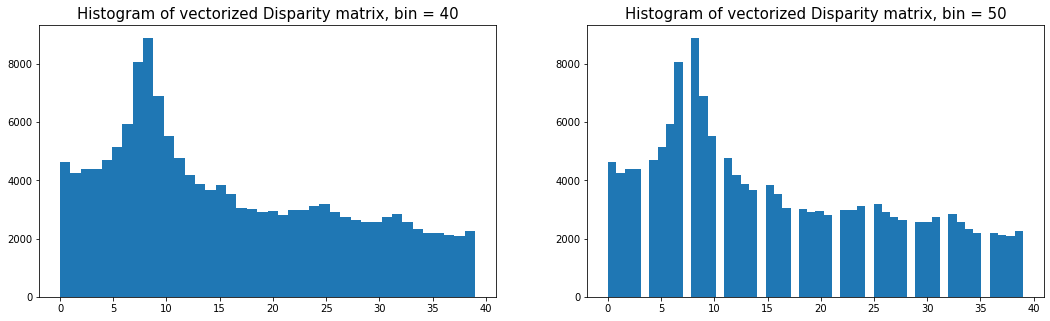

In [8]:
D_vec = D.flatten()
print(f'D_vec shape is {D_vec.shape}')


fig = plt.figure(figsize=(18,5))
fig.add_subplot(1, 2, 1)
plt.hist(D_vec, bins=40)
plt.title("Histogram of vectorized Disparity matrix, bin = 40", fontsize = 15)


fig.add_subplot(1, 2, 2)
plt.hist(D_vec, bins=50)
plt.title("Histogram of vectorized Disparity matrix, bin = 50", fontsize = 15)
plt.show()

**With bin size = 50 we can see 11 clusters are being formed**

### **Guassian representation of the Disparity Data**

In [9]:
def pdf_dist_normal(mu, variance, x):
  return (1/np.sqrt(2*np.pi*(variance))) * (np.exp(-(((x-mu)**2)/(2*variance))))

In [10]:
df = pd.DataFrame({'Disparity': D_vec})
df.head()

Disparity
0          5
1         13
2         11
3          7
4          7

In [11]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [12]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# X =D_vec.reshape(-1,1)

np.random.seed(42)
gmm = GMM(k=10, max_iter=100)
gmm.fit(D_vec.reshape(-1,1))

In [13]:
clus = gmm.predict(D_vec)

In [14]:
df['clus'] = clus

In [15]:
df

Disparity  clus
0               5     5
1              13     0
2              11     0
3               7     5
4               7     5
...           ...   ...
148585         18     4
148586          4     5
148587         28     1
148588         32     1
148589         33     1

[148590 rows x 2 columns]

In [16]:
df.clus.unique()

array([5, 0, 6, 2, 1, 7, 4, 3])

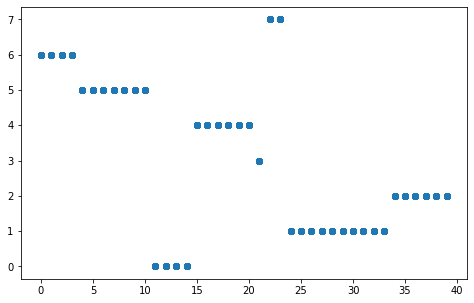

In [17]:
fig = plt.figure(figsize=(8,5))
plt.scatter(df.Disparity, df.clus)
plt.show()

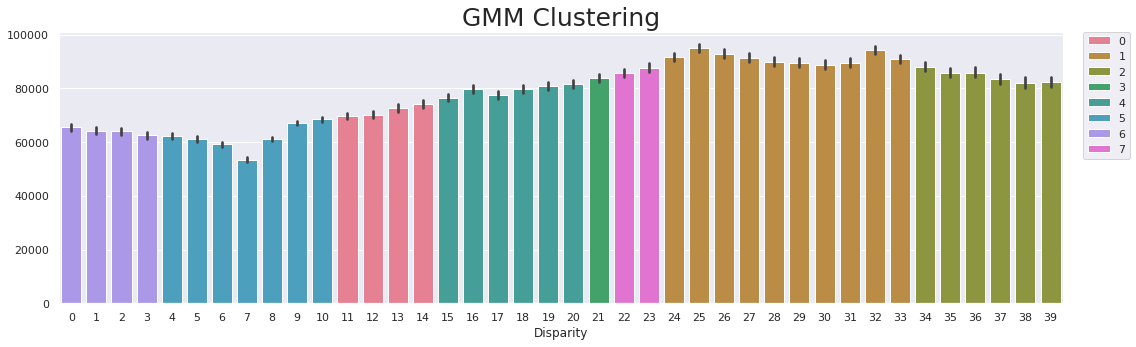

In [18]:
sns.set(rc={'figure.figsize':(18,5)})
ax = sns.barplot(x=df['Disparity'], y = df.index, hue=df['clus'],
                 palette='husl', dodge=False)
#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("GMM Clustering", fontsize = 25)
plt.show()

In [19]:
centriods = gmm.mu
sigmas = gmm.sigma
print(centriods)
print(sigmas)

[array([10.7938216]), array([27.62614741]), array([35.6324903]), array([21.19277153]), array([16.13286615]), array([6.99964965]), array([1.6085757]), array([25.09870513]), array([10.7938216]), array([35.6324903])]
[array([[15.95537238]]), array([[19.92969956]]), array([[6.03543319]]), array([[38.35836084]]), array([[20.58139946]]), array([[4.21585956]]), array([[1.74639678]]), array([[29.16067176]]), array([[15.95537238]]), array([[6.03543319]])]


In [20]:
df['depth_map'] = df['clus']
df.head()

Disparity  clus  depth_map
0          5     5          5
1         13     0          0
2         11     0          0
3          7     5          5
4          7     5          5

In [21]:
depth_map = np.array(df['clus'], dtype=float)

for i in range(len(centriods)):
    depth_map[depth_map == i] = centriods[i]

In [22]:
df['depth_map'] = depth_map
df.head()

Disparity  clus  depth_map
0          5     5   6.999650
1         13     0  10.793822
2         11     0  10.793822
3          7     5   6.999650
4          7     5   6.999650

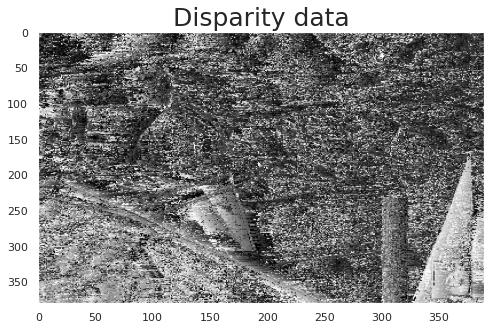

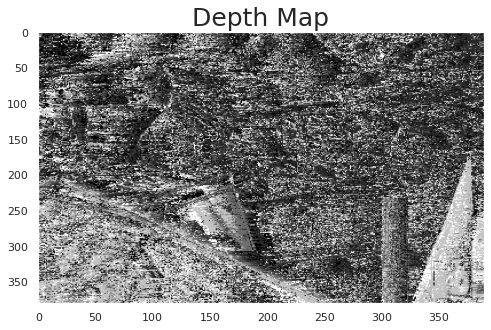

In [23]:
# Plotting the clustered images with the Disparuty data and Depth Map
plt.figure(figsize=(8,5))
plt.imshow(np.array(df['Disparity']).reshape((381, 390)),cmap="gray", aspect = 'auto')
plt.title("Disparity data", fontsize = 25)
plt.grid(False)
plt.show()

plt.figure(figsize=(8,5))
plt.imshow(np.array(df['depth_map']).reshape((381, 390)),cmap="gray", aspect = 'auto')
plt.title("Depth Map", fontsize = 25)
plt.grid(False)
plt.show()

# plt.figure(figsize=(8,5))
# plt.imshow(np.array(df['clus']).reshape((381, 390)),cmap="gray", aspect = 'auto')
# plt.title("Cluster values", fontsize = 25)
# plt.grid(False)
# plt.show()

### MRF Smoothing and Gibbs sampling  implementation


**Implementation with the MRF’s smoothing priors using an eight neighborhood
system**


In [24]:
clus_list = []
smooth_centriod_map = np.array(df.clus).reshape(D.shape)
prev_cluster_map = np.array(df.clus).reshape(D.shape)
smoothened_depth_map = np.zeros(D.shape)

def similarity_pixel_finder(i, j, cluster):
    if i < 0 or \
      j < 0 or \
      i > prev_cluster_map.shape[0]-1 or \
      j > prev_cluster_map.shape[1]-1 or \
      prev_cluster_map[i,j] == cluster:
        return 1
    
    a = 5
    sigma = 0.5
    if prev_cluster_map[i,j] == cluster:
        a = 0
    return np.exp(-(a*a/(2*sigma*sigma)))


def prior_calculator(i,j,cluster):
    N = [-1,0,1]
    prior_p = 1

    for k in N:
        for l in N:
            prior_p *= similarity_pixel_finder(i+k,j+l, cluster)
    return prior_p

In [25]:
cluster_map = np.array(df.clus)
cluster_map = cluster_map.reshape(D.shape)
depth_map = depth_map.reshape(D.shape)

In [26]:
def pdf_dist_normal(mu, sigma, x):
    pdf = (1/np.sqrt((2*np.pi*(sigma**2)))) * (np.exp(-(((x-mu)**2)/(2*(sigma**2)))))
    return pdf

In [27]:
unique_clus = len(df.clus.unique())
np.sort(df.clus.unique())

array([0, 1, 2, 3, 4, 5, 6, 7])

In [28]:
%%time
for iter in range(30):
  for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        current_cluster = cluster_map[i,j]
        posterior = np.zeros(unique_clus)

        for k in range(unique_clus):
            posterior[k] = pdf_dist_normal(centriods[k], sigmas[k], depth_map[i,j]) * prior_calculator(i,j,k)

        posterior = posterior/np.sum(posterior)
        new_label = np.random.choice(np.arange(0, unique_clus), p=posterior)
        smoothened_depth_map[i,j] = centriods[new_label]
        smooth_centriod_map[i,j] = new_label

  clus_list.append(smoothened_depth_map)
  prev_cluster_map = np.array(smooth_centriod_map)

CPU times: user 33min 12s, sys: 1min 17s, total: 34min 30s
Wall time: 34min 21s


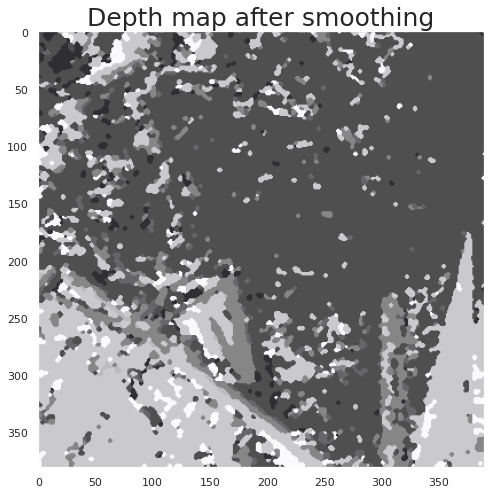

In [29]:
c_array = np.array(clus_list)
smoothened_final_map = scipy.stats.mode(c_array[-10:])[0][0]

plt.figure(figsize=(8,15))
plt.title('Depth map after smoothing', fontsize = 25)
plt.imshow(smoothened_final_map,cmap="gray", alpha=0.8)
plt.grid(False)
plt.show()


## **P2: Probabilistic Latent Semantic Indexing (PLSI) for Speech Denoising**

- https://towardsdatascience.com/topic-modelling-with-plsa-728b92043f41
- https://www.analyticsvidhya.com/blog/2021/05/complete-guide-to-expectation-maximization-algorithm/
- https://www.analyticsvidhya.com/blog/2021/06/part-17-step-by-step-guide-to-master-nlp-topic-modelling-using-plsa/



In [340]:
!ls $dirpath

'HW_1 data'  'HW_3 data'   im0.ppm   tes.wav   trn.wav	 twitter.mat
'HW_2 data'   HW4	   im8.ppm   tex.wav   trs.wav


In [341]:
trs, sr1 = librosa.load(dirpath + 'trs.wav' , sr = None)
trn, sr1 = librosa.load(dirpath + 'trn.wav' , sr = None)
tex, sr1 = librosa.load(dirpath + 'tex.wav' , sr = None)
tes, sr1 = librosa.load(dirpath + 'tes.wav' , sr = None)

**Original S and N i.e sound and noise signals**

In [342]:
Audio(trs, rate = sr1)

In [343]:
Audio(trn, rate = sr1)

In [344]:
Audio(tex, rate = sr1)

In [345]:
Audio(tes, rate = sr1)

In [346]:
S = librosa.stft(trs,  n_fft=1024, hop_length  = 512,  window='hann')
N = librosa.stft(trn,  n_fft=1024, hop_length  = 512,  window='hann')

In [347]:
S.shape , N.shape

((513, 893), (513, 893))

In [348]:
X = librosa.stft(tex,  n_fft=1024, hop_length  = 513,  window='hann')
X_test = librosa.stft(tes,  n_fft=1024, hop_length  = 513,  window='hann')

In [349]:
X.shape, X_test.shape

((513, 160), (513, 160))

**Spectrogram X**

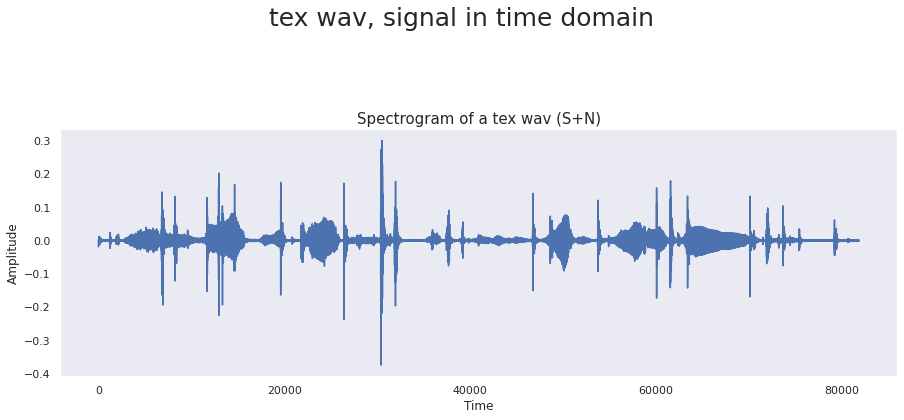

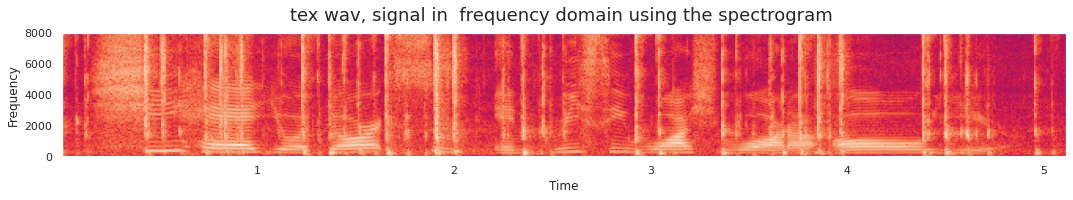

In [350]:
# Plot the signal read from wav file

plt.figure(figsize = (15,10))
plt.subplot(211)
plt.suptitle("tex wav, signal in time domain ", y=1.05, fontsize=25)
plt.title('Spectrogram of a tex wav (S+N)', fontsize=15)
plt.plot(tex)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(False)
plt.show()

plt.subplot(212)
plt.specgram(tex ,Fs = sr1)
plt.title("tex wav, signal in  frequency domain using the spectrogram ",  y=1.05, fontsize=18)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

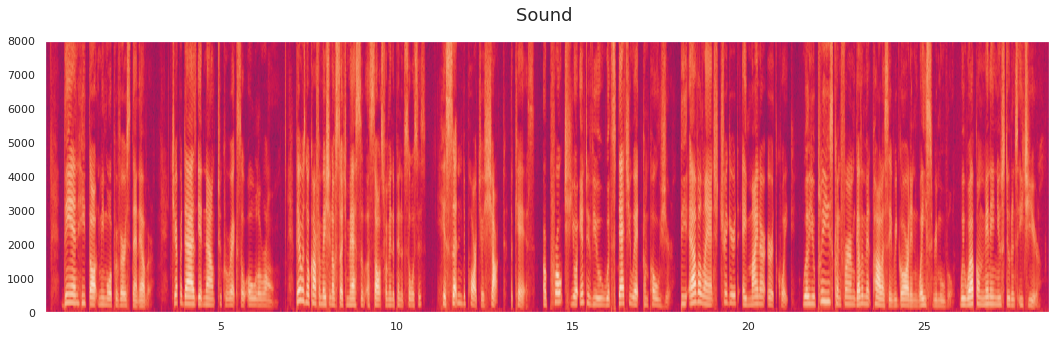

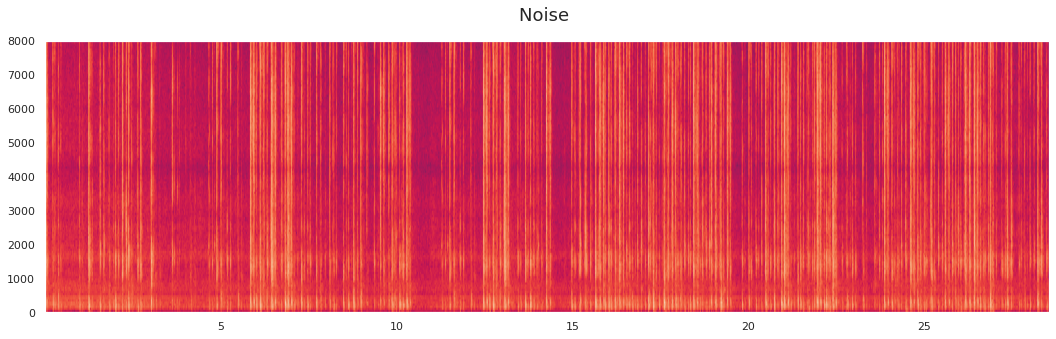

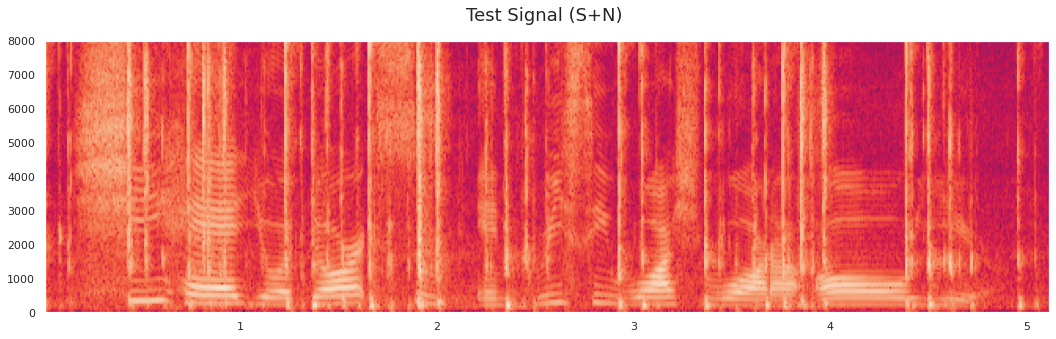

In [351]:
plt.specgram(trs ,Fs = sr1)
plt.title("Sound ",  y=1.05, fontsize=18)
plt.grid(False)
plt.show()

plt.specgram(trn ,Fs = sr1)
plt.title("Noise ",  y=1.05, fontsize=18)
plt.grid(False)
plt.show()

plt.specgram(tex ,Fs = sr1)
plt.title("Test Signal (S+N) ",  y=1.05, fontsize=18)
plt.grid(False)
plt.show()

In [352]:
# np.set_printoptions(suppress=True)
# df = pd.DataFrame({'S': np.abs(S[:,0]),
#                    'N': np.abs(N[:,0]),
#                    'X': np.abs(X[:,0])})
# df

In [353]:
print("S shape:       ",S.shape)
print("N shape:       ",N.shape)
print("X shape:       ",X.shape)
print("X_test shape:  ",X_test.shape)

S shape:        (513, 893)
N shape:        (513, 893)
X shape:        (513, 160)
X_test shape:   (513, 160)


### **Step 1: PLSI on Sound S signal**

In [354]:
%%time

# initialize parameters
k = 30
epochs = 4000
epsilon =  1e-8


B_1 = np.random.randn(513, k)
theta_1 = np.random.randn(k, 893) 


print(f'B_1 shape :  {B_1.shape}, Theta_1 shape:   {theta_1.shape}')

S_mag = np.abs(S)

for i in range(epochs):
    # weights update
    den = np.dot(B_1,theta_1)
    den[den == 0] = epsilon
    B_1 =  np.multiply(B_1, np.dot((S_mag / den), theta_1.T)) 
    
    den = np.dot(B_1,theta_1)
    den[den == 0] = epsilon
    theta_1 = theta_1 * np.dot(B_1.T, (S_mag / den))
    
    # normalization
    B_1[B_1 == 0] = epsilon
    B_1 = B_1 / np.dot(np.ones([B_1.shape[0], B_1.shape[0]]), B_1)
    theta_1 = theta_1 / np.dot(np.ones([theta_1.shape[0], theta_1.shape[0]]), theta_1)

B_1 shape :  (513, 30), Theta_1 shape:   (30, 893)
CPU times: user 1min 59s, sys: 49.7 s, total: 2min 49s
Wall time: 1min 27s


### **Step 2: PLSI on Noise N signal**

In [355]:
%%time

# initialize parameters for ta
B_2 = np.random.randn(513, k) 
theta_2 = np.random.randn(k, 893) 

print(f'B_2 shape :  {B_2.shape}, Theta_2 shape:   {theta_2.shape}')

N_mag = np.abs(N)

for i in range(epochs):
    # weights update
    den = np.dot(B_2,theta_2)
    den[den == 0] = epsilon
    B_2 = np.multiply(B_2, np.dot((N_mag / den), theta_2.T))
    
    den = np.dot(B_2, theta_2)
    den[den == 0] = epsilon
    theta_2 = np.multiply(theta_2, np.dot(B_2.T, (N_mag / den)))
    
    #normalization
    B_2[B_2 == 0] = epsilon
    B_2 = B_2 / np.dot(np.ones([B_2.shape[0], B_2.shape[0]]), B_2)
    theta_2 = theta_2 / np.dot(np.ones([theta_2.shape[0], theta_2.shape[0]]), theta_2)

B_2 shape :  (513, 30), Theta_2 shape:   (30, 893)
CPU times: user 1min 55s, sys: 46.9 s, total: 2min 42s
Wall time: 1min 23s


In [356]:
B_1.shape, B_2.shape , theta_2.shape

((513, 30), (513, 30), (30, 893))

In [357]:
print(X.shape)

(513, 160)


### **Step 3: PLSA routine to learn theta**

In [358]:
%%time
B_mat = np.hstack([B_1, B_2])
theta_3 =  np.random.randn(B_mat.shape[1], X.shape[1]) 
print(f'B_mat shape :  {B_mat.shape}, Theta_3 shape:   {theta_3.shape}')
print("B_mat, theta : ",B_mat.shape, theta_3.shape)
print("B_mat, X :", B_mat.shape, X.shape )

X_mag = np.abs(X)

for i in range(epochs):
    # theta_3 update 
    den = np.dot(B_mat, theta_3)
    den[den == 0] = epsilon
    
    theta_3 = np.multiply(theta_3, np.dot(B_mat.T,(X_mag / den)))
    theta_3 = theta_3 / np.dot(np.ones([theta_3.shape[0], theta_3.shape[0]]), theta_3)

B_mat shape :  (513, 60), Theta_3 shape:   (60, 160)
B_mat, theta :  (513, 60) (60, 160)
B_mat, X : (513, 60) (513, 160)
CPU times: user 40.3 s, sys: 11.5 s, total: 51.8 s
Wall time: 26.6 s


In [359]:
X_mag.shape, B_mat.shape , theta_3.shape

((513, 160), (513, 60), (60, 160))

In [360]:
B_1.shape , theta_3[:k, :].shape

((513, 30), (30, 160))

In [361]:
B_mat.shape, theta_3.shape

((513, 60), (60, 160))

**S_test_hat calculation**

In [362]:
num_val = np.dot(B_1 , theta_3[:k, :])
num_val.shape

(513, 160)

In [363]:
denom_val = np.dot(B_mat, theta_3)
denom_val.shape

(513, 160)

In [364]:
X_test_hat = np.multiply(X , num_val / denom_val) 
X_test_hat.shape

(513, 160)

**Recovered Test signal**

In [365]:
X_rec  = librosa.istft(X_test_hat, hop_length  = 512)
Audio(X_rec , rate = sr1)

In [366]:
# S_recov = S_recov.reshape(513, -1)
# S_recov.shape, X_test.shape


In [367]:
def snr_calculate(S, S_recov):
  return 10 *  (np.log10(np.sum(S ** 2)/ (np.sum((S-S_recov) **2 ))))

X_test_mag = np.abs(X_test)
X_test_hat_mag = np.abs(X_test_hat)
print(f'SNR value of the separation result by comparing is: {np.abs(snr_calculate(X_test_mag, X_test_hat_mag))}')

SNR value of the separation result by comparing is: 6.428571878337359


In [368]:
X_test_hat_mag.shape

(513, 160)

In [381]:
# plt.specgram(X_test_hat_mag.flatten() ,Fs = sr1)
# plt.title("Test Signal (S+N) ",  y=1.05, fontsize=18)
# plt.grid(False)
# plt.show()

## **P3: PLSI for Analyzing Twitter Stream**

In [485]:
twitter = scipy.io.loadmat(dirpath + 'twitter.mat')

Xtr = twitter['Xtr']
Xte = twitter['Xte']
YtrMat = twitter['YtrMat']
YteMat = twitter['YteMat']

In [486]:
Xtr.shape , Xte.shape

((891, 773), (891, 193))

In [487]:
YtrMat.shape, YteMat.shape

((3, 773), (3, 193))

In [488]:
topics = np.random.randn(891, 50)
weights = np.random.randn(50, 773)

In [489]:
for i in range(2000):

    den = np.dot(topics,weights)
    den[den == 0] = 0.0001

    topics = topics * np.dot((Xtr/den), weights.T)
    topics = topics / np.dot(np.ones([topics.shape[0], topics.shape[0]]), topics)

    den = np.dot(topics,weights)
    den[den == 0] = 0.0001

    weights = weights * np.dot(topics.T, (Xtr/den))
    weights = weights / np.dot(np.ones([weights.shape[0], weights.shape[0]]), weights)

In [511]:
weights2 = np.random.rand(50,193)

for i in range(2000):

    den = np.dot(topics, weights2)
    den[den == 0] = 0.0001

    weights2 = weights2 * np.dot(topics.T, (Xte/den))
    weights2 = weights2 / np.dot(np.ones([weights2.shape[0], weights2.shape[0]]), weights2)

Perceptron Neural Network definition

In [512]:
alpha = 0.0005

W = np.random.uniform(0, 6, (3, weights.shape[0]))
b = np.random.uniform(0, 6, (3,1))
error_plot = []

for i in range(5000):

    Y_hat = np.exp(np.dot(W, weights) + b)
    Y_hat = Y_hat / np.sum(Y_hat, axis=0).reshape(1,-1)
    
    error = -np.sum(YtrMat * np.log(Y_hat))

    delta_w = np.dot((Y_hat - YtrMat), weights.T)
    delta_b = np.dot((Y_hat - YtrMat), np.ones([YtrMat.shape[1],1]))
    
    W = W - (alpha * delta_w)
    b = b - (alpha * delta_b)

    error_plot.append(error)

In [513]:
Z = np.dot(W, weights2) + b
Y_hat_test = np.exp(Z)

Y_hat_test = Y_hat_test / np.sum(Y_hat_test, axis=0).reshape(1,-1)

train_accuracy = np.sum(np.argmax(Y_hat, axis=0) == np.argmax(YtrMat, axis=0)) / YtrMat.shape[1]
test_accuracy = np.sum(np.argmax(Y_hat_test, axis=0) == np.argmax(YteMat, axis=0)) / YteMat.shape[1]

In [514]:
print('Training accuacy is: ' ,np.round(train_accuracy, 4) * 100)
print('Testing accuacy is: ' , np.round(test_accuracy, 4) * 100)

Training accuacy is:  60.8
Testing accuacy is:  54.400000000000006


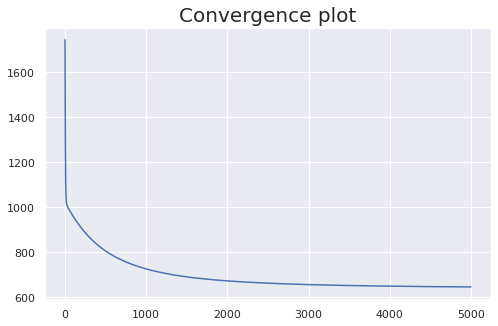

In [515]:
plt.figure(figsize=(8, 5))
plt.title('Convergence plot', fontsize = 20)
plt.plot(error_plot)
plt.show()

## **References**



- http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/ <br>
- https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566


## **Final: Convert the notebook to HTML**

In [516]:
# %%shell
# jupyter nbconvert --to html /content/AG_MLSP_SP22_HW_6.ipynb

# **The END**